Step 1: Install and Load Necessary Libraries



In [1]:
library("DESeq2") # bioconductor package
library(ggplot2)
library(scales) # needed for oob parameter
library(viridis)
# Convert the VST counts to long format for ggplot2
library(reshape2)
library(gtable)
library(grid)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loa

Step 2: Load and Prepare the Data



In [2]:
# Read in the raw read counts
rawCounts <- read.delim("http://genomedata.org/gen-viz-workshop/intro_to_deseq2/tutorial/E-GEOD-50760-raw-counts.tsv")
# Read in the sample mappings
sampleData <- read.delim("http://genomedata.org/gen-viz-workshop/intro_to_deseq2/tutorial/E-GEOD-50760-experiment-design.tsv")


In [3]:
# Also save a copy for later
sampleData_v2 <- sampleData

Step 3: preparing the dataset

In [4]:
# Convert count data to a matrix of appropriate form that DEseq2 can read
geneID <- rawCounts$Gene.ID
sampleIndex <- grepl("SRR\\d+", colnames(rawCounts))
rawCounts <- as.matrix(rawCounts[,sampleIndex])
rownames(rawCounts) <- geneID
#head(rawCounts)
# Convert sample variable mappings to an appropriate form that DESeq2 can read

rownames(sampleData) <- sampleData$Run
keep <- c("Sample.Characteristic.biopsy.site.", "Sample.Characteristic.individual.")
sampleData <- sampleData[,keep]
colnames(sampleData) <- c("tissueType", "individualID")
sampleData$individualID <- factor(sampleData$individualID)


# Put the columns of the count data in the same order as rows names of the sample mapping, then make sure it worked
rawCounts <- rawCounts[,unique(rownames(sampleData))]
all(colnames(rawCounts) == rownames(sampleData))


# rename the tissue types
rename_tissues <- function(x){
  x <- switch(as.character(x), "normal"="normal-looking surrounding colonic epithelium", "primary tumor"="primary colorectal cancer",  "colorectal cancer metastatic in the liver"="metastatic colorectal cancer to the liver")
  return(x)
}
sampleData$tissueType <- unlist(lapply(sampleData$tissueType, rename_tissues))
# Order the tissue types so that it is sensible and make sure the control sample is first: normal sample -> primary tumor -> metastatic tumor
sampleData$tissueType <- factor(sampleData$tissueType, levels=c("normal-looking surrounding colonic epithelium", "primary colorectal cancer", "metastatic colorectal cancer to the liver"))


[1] TRUE

Step 3: Create DESeq2 Dataset


In [5]:
deseq2Data <- DESeqDataSetFromMatrix(countData=rawCounts, colData=sampleData, design= ~ individualID + tissueType)

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



Step 4: Pre-filtering

In [6]:
#dim(deseq2Data)
#dim(deseq2Data[rowSums(counts(deseq2Data)) > 5, ])

# Perform pre-filtering of the data
deseq2Data <- deseq2Data[rowSums(counts(deseq2Data)) > 5, ]

Step 5: Differential Expression Analysis


In [7]:
deseq2Data <- DESeq(deseq2Data)
# Extract differential expression results
# For "tissueType" perform primary vs normal comparison
deseq2Results <- results(deseq2Data, contrast=c("tissueType", "primary colorectal cancer", "normal-looking surrounding colonic epithelium"))

# View summary of results
summary(deseq2Results)

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

fitting model and testing




out of 35179 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 4816, 14%
LFC < 0 (down)     : 5718, 16%
outliers [1]       : 0, 0%
low counts [2]     : 10231, 29%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Step 6: Visualize the Results


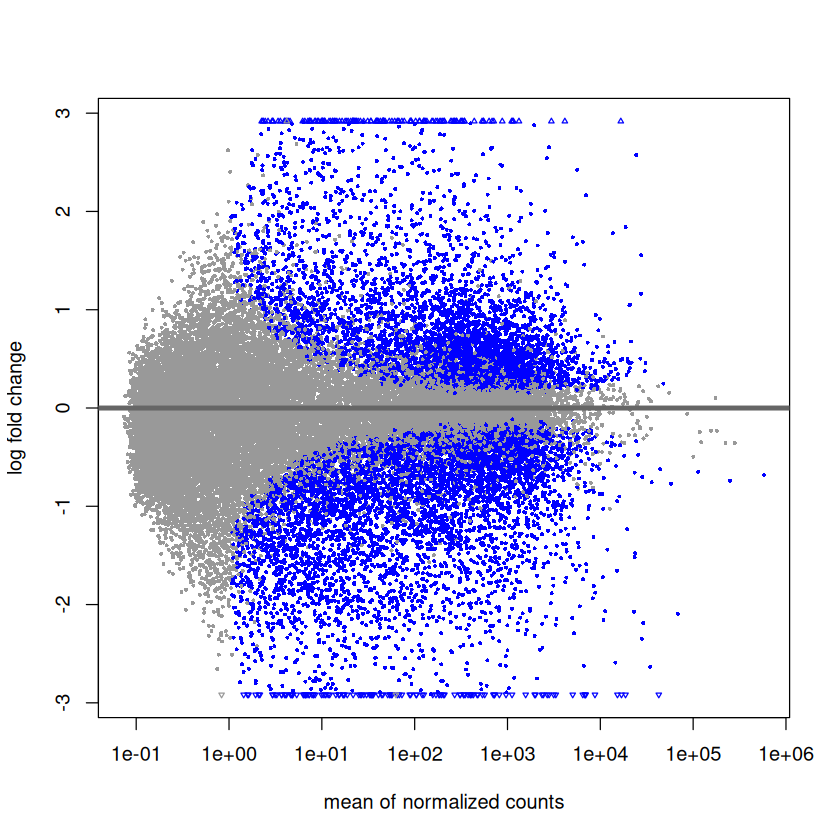

In [8]:
# Using DEseq2 built in method
plotMA(deseq2Results)

Step 7: Extract Significant Results


In [9]:
# Coerce to a data frame
deseq2ResDF <- as.data.frame(deseq2Results)
# Set a boolean column for significance
deseq2ResDF$significant <- ifelse(deseq2ResDF$padj < .1, "Significant", NA)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


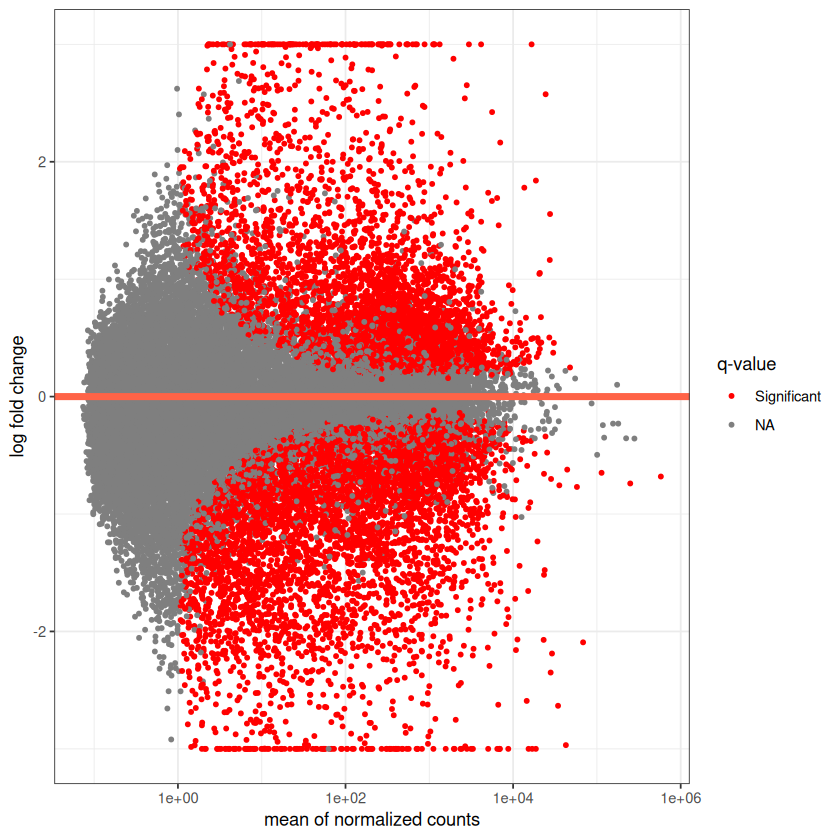

In [10]:
# Plot the results similar to DEseq2
ggplot(deseq2ResDF, aes(baseMean, log2FoldChange, colour=significant)) + geom_point(size=1) + scale_y_continuous(limits=c(-3, 3), oob=squish) + scale_x_log10() + geom_hline(yintercept = 0, colour="tomato1", size=2) + labs(x="mean of normalized counts", y="log fold change") + scale_colour_manual(name="q-value", values=("Significant"="red"), na.value="grey50") + theme_bw()


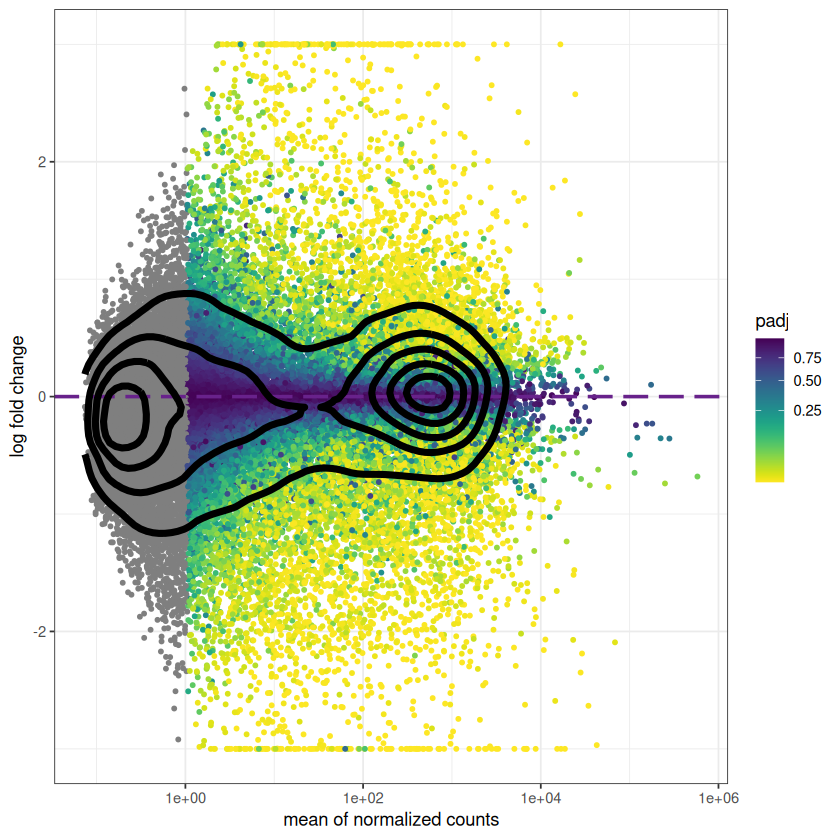

In [11]:
# Let's add some more detail
ggplot(deseq2ResDF, aes(baseMean, log2FoldChange, colour=padj)) + geom_point(size=1) + scale_y_continuous(limits=c(-3, 3), oob=squish) + scale_x_log10() + geom_hline(yintercept = 0, colour="darkorchid4", size=1, linetype="longdash") + labs(x="mean of normalized counts", y="log fold change") + scale_colour_viridis(direction=-1, trans='sqrt') + theme_bw() + geom_density_2d(colour="black", size=2)


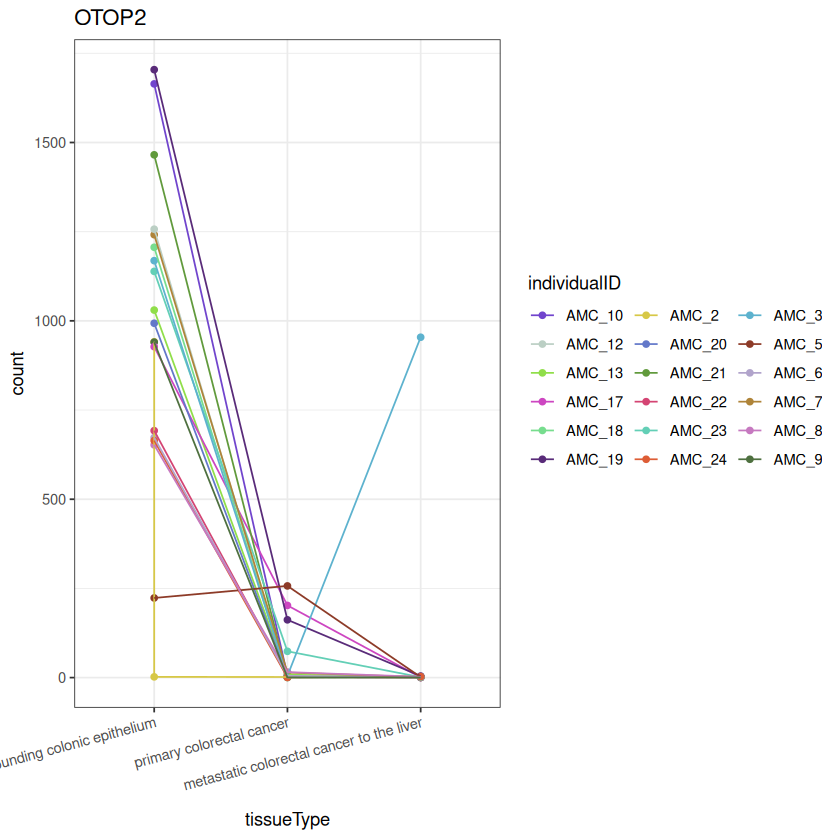

In [12]:
# Extract counts for the gene otop2
otop2Counts <- plotCounts(deseq2Data, gene="ENSG00000183034", intgroup=c("tissueType", "individualID"), returnData=TRUE)
# Plot the data using ggplot2
colourPallette <- c("#7145cd","#bbcfc4","#90de4a","#cd46c1","#77dd8e","#592b79","#d7c847","#6378c9","#619a3c","#d44473","#63cfb6","#dd5d36","#5db2ce","#8d3b28","#b1a4cb","#af8439","#c679c0","#4e703f","#753148","#cac88e","#352b48","#cd8d88","#463d25","#556f73")
ggplot(otop2Counts, aes(x=tissueType, y=count, colour=individualID, group=individualID)) + geom_point() + geom_line() + theme_bw() + theme(axis.text.x=element_text(angle=15, hjust=1)) + scale_colour_manual(values=colourPallette) + guides(colour=guide_legend(ncol=3)) + ggtitle("OTOP2")

In [13]:
# Transform count data using the variance stablilizing transform
deseq2VST <- vst(deseq2Data)
# Convert the DESeq transformed object to a data frame
deseq2VST <- assay(deseq2VST)
deseq2VST <- as.data.frame(deseq2VST)
deseq2VST$Gene <- rownames(deseq2VST)

In [14]:
# Keep only the significantly differentiated genes where the fold-change was at least 3
sigGenes <- rownames(deseq2ResDF[deseq2ResDF$padj <= .05 & abs(deseq2ResDF$log2FoldChange) > 3,])
deseq2VST <- deseq2VST[deseq2VST$Gene %in% sigGenes,]


In [15]:
# First compare wide vs long version
deseq2VST_wide <- deseq2VST
deseq2VST_long <- melt(deseq2VST, id.vars=c("Gene"))
# Now overwrite our original data frame with the long format
deseq2VST <- melt(deseq2VST, id.vars=c("Gene"))

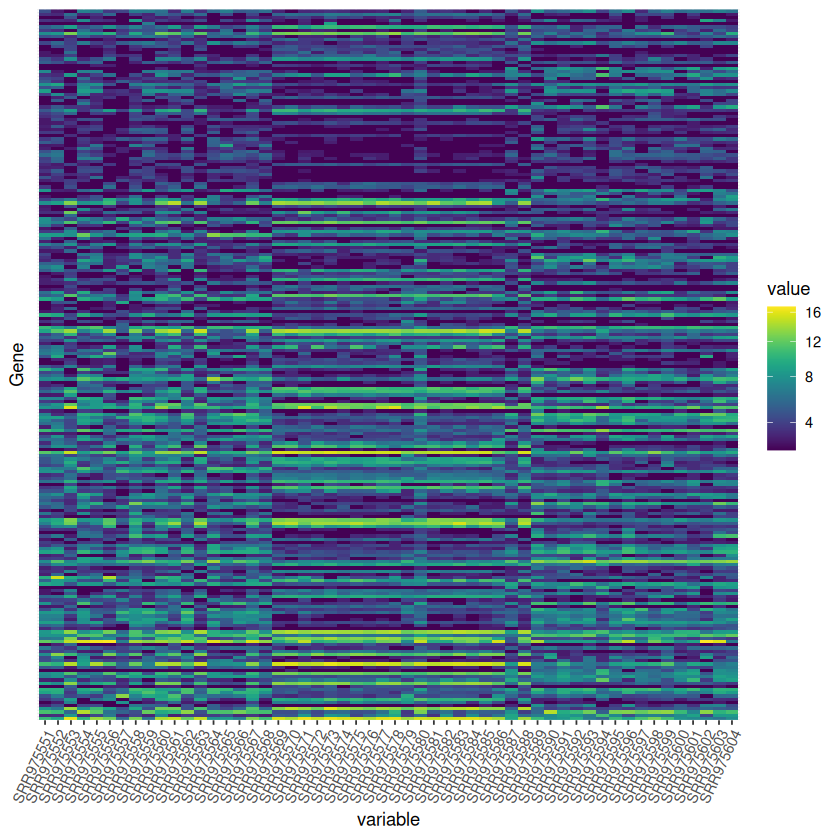

In [16]:
# Make a heatmap
heatmap <- ggplot(deseq2VST, aes(x=variable, y=Gene, fill=value)) + geom_raster() + scale_fill_viridis(trans="sqrt") + theme(axis.text.x=element_text(angle=65, hjust=1), axis.text.y=element_blank(), axis.ticks.y=element_blank())
heatmap

In [17]:
# Convert the significant genes back to a matrix for clustering
deseq2VSTMatrix <- dcast(deseq2VST, Gene ~ variable)
rownames(deseq2VSTMatrix) <- deseq2VSTMatrix$Gene
deseq2VSTMatrix$Gene <- NULL

In [18]:
# Compute a distance calculation on both dimensions of the matrix
distanceGene <- dist(deseq2VSTMatrix)
distanceSample <- dist(t(deseq2VSTMatrix))


In [19]:
# Cluster based on the distance calculations
clusterGene <- hclust(distanceGene, method="average")
clusterSample <- hclust(distanceSample, method="average")

In [20]:
# Construct a dendogram for samples

library(ggdendro)
sampleModel <- as.dendrogram(clusterSample)
sampleDendrogramData <- segment(dendro_data(sampleModel, type = "rectangle"))
sampleDendrogram <- ggplot(sampleDendrogramData) + geom_segment(aes(x = x, y = y, xend = xend, yend = yend)) + theme_dendro()

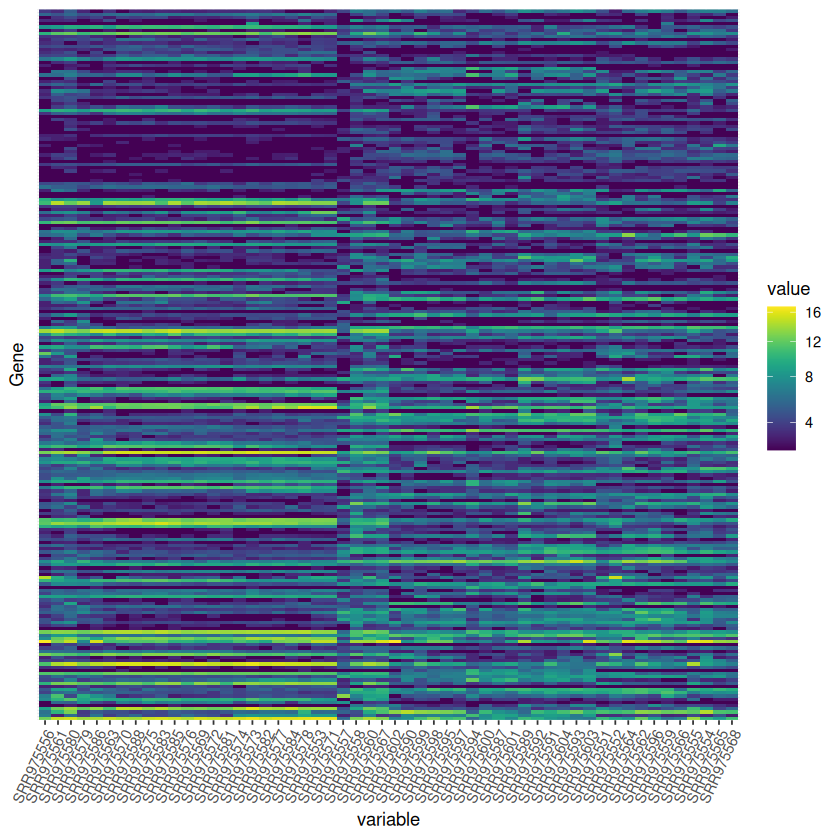

In [21]:
# Re-factor samples for ggplot2
deseq2VST$variable <- factor(deseq2VST$variable, levels=clusterSample$labels[clusterSample$order])

# Construct the heatmap. note that at this point we have only clustered the samples NOT the genes
heatmap <- ggplot(deseq2VST, aes(x=variable, y=Gene, fill=value)) + geom_raster() + scale_fill_viridis(trans="sqrt") + theme(axis.text.x=element_text(angle=65, hjust=1), axis.text.y=element_blank(), axis.ticks.y=element_blank())
heatmap


Attaching package: ‘gridExtra’


The following object is masked from ‘package:Biobase’:

    combine


The following object is masked from ‘package:BiocGenerics’:

    combine




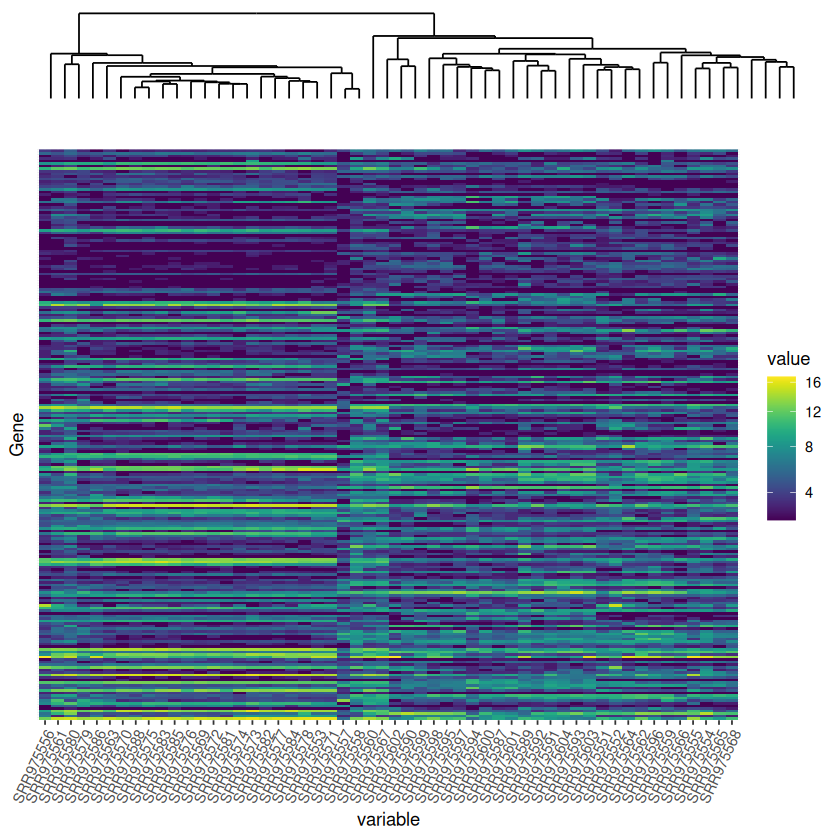

In [22]:
# Combine the dendrogram and the heatmap
#install.packages("gridExtra")
library(gridExtra)
grid.arrange(sampleDendrogram, heatmap, ncol=1, heights=c(1,5))